In [1]:
import torch 
import torchvision
import torch.nn as nn
import numpy as np
from torch.autograd import Variable
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets

import matplotlib.pyplot as plt

In [2]:
directory = "/home/ubuntu/housenumber/data1"

## DataLoader

In [3]:
import torch.utils.data as data
from PIL import Image
import os
import os.path
import numpy as np

class SVHNDataset(data.Dataset):
    
    url = ""
    filename = ""
    file_md5 = ""
    
    split_list = {
        'train': ["http://ufldl.stanford.edu/housenumbers/train_32x32.mat",
                  "train_32x32.mat", "e26dedcc434d2e4c54c9b2d4a06d8373"],
        'test': ["http://ufldl.stanford.edu/housenumbers/test_32x32.mat",
                 "test_32x32.mat", "eb5a983be6a315427106f1b164d9cef3"]}
    
    
    
    def __init__(self, root, split='train',
                 transform=None,color_channel=True):
        
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.color_channel = color_channel
        
        #
        self.split = split  # training set or test set or extra set

        
        self.url = self.split_list[split][0]
        self.filename = self.split_list[split][1]
        self.file_md5 = self.split_list[split][2]
        
        
        # import here rather than at top of file because this is
        # an optional dependency for torchvision
        import scipy.io as sio

        # reading(loading) mat file as array
        loaded_mat = sio.loadmat(os.path.join(self.root, self.filename))

        self.data = loaded_mat['X']
        # loading from the .mat file gives an np array of type np.uint8
        # converting to np.int64, so that we have a LongTensor after
        # the conversion from the numpy array
        # the squeeze is needed to obtain a 1D tensor
        self.labels = loaded_mat['y'].astype(np.int64).squeeze()

        # the svhn dataset assigns the class label "10" to the digit 0
        # this makes it inconsistent with several loss functions
        # which expect the class labels to be in the range [0, C-1]
        np.place(self.labels, self.labels == 10, 0)
        self.data = np.transpose(self.data, (3, 2, 0, 1))

    
    def __getitem__(self, index):
        
        img, target = self.data[index], int(self.labels[index])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(np.transpose(img, (1, 2, 0)))
        
        if (self.color_channel is not True):
            img = img.convert('L')
        
        if self.transform is not None:
            img = self.transform(img)

        return img, target


    def __len__(self):
        return len(self.data)
    

In [4]:
# how many samples per batch to load
batch_size = 20

# number of subprocesses to use for data loading
num_workers = 0

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),                                
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])



def get_dataset(root,color_channel = False): #you are free to change parameters
    train_data = SVHNDataset(root=directory,split='train',transform=transform,color_channel=color_channel)
    test_data = SVHNDataset(root=directory,split='test',transform=transform,color_channel=color_channel)
    return train_data,test_data

# 3.1. Multi Layer Perceptron

In [5]:
train_data,test_data = get_dataset(root=directory,color_channel = False)


# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)

## Visualizing image

Image size :  (1, 32, 32)


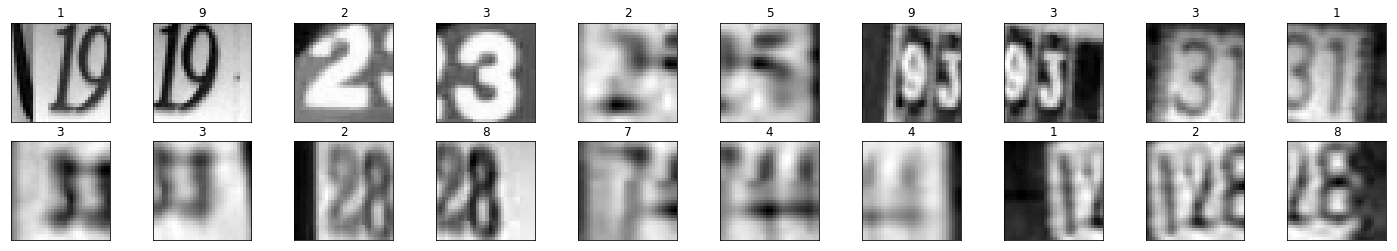

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
print("Image size : ",images[0].shape)
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

## Neural Network

In [8]:
class FCNet(nn.Module):
    '''Define your neural network'''
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1024, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        
        return x

## Training and Testing

In [9]:
from torch.utils.data.sampler import SubsetRandomSampler


# Pick your hyper parameters

valid_size = 0.2
max_epoch = 20
batch_size = 20
learning_rate = 0.003

use_gpu = torch.cuda.is_available()

import torch.optim as optim
import torch.nn.functional as F

def main():

    train_data,test_data = get_dataset(root=directory)

    
    # obtain training indices that will be used for validation
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:],indices[:split]


    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)


    # prepare data loaders (combine dataset and sampler)
    train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,
                                               sampler=train_sampler,num_workers=num_workers)

    valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
        sampler=valid_sampler, num_workers=num_workers)
    
    
    
    model = FCNet()
    criterion = nn.NLLLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=
                                                0.9, weight_decay=5e-04)
    
    if use_gpu:
        model.cuda()
    
    # start training
    train(max_epoch, model, criterion, optimizer, train_loader,valid_loader)
    
    return model

In [10]:
def train(epoch, model, criterion, optimizer, train_loader,valid_loader):
    
    valid_loss_min = np.Inf # track change in validation loss

    for epoch in range(1, max_epoch+1):

        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        model.train()
        for data, target in train_loader:
            # move tensors to GPU if CUDA is available
            if use_gpu:
                data, target = data.cuda(), target.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*data.size(0)

        ######################    
        # validate the model #
        ######################
        model.eval()
        for data, target in valid_loader:
            # move tensors to GPU if CUDA is available
            if use_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)

        # calculate average losses
        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(valid_loader.dataset)

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'model_housenumber.pt')
            valid_loss_min = valid_loss

In [11]:
model  = main()

Epoch: 1 	Training Loss: 1.327019 	Validation Loss: 0.226566
Validation loss decreased (inf --> 0.226566).  Saving model ...
Epoch: 2 	Training Loss: 0.782893 	Validation Loss: 0.176387
Validation loss decreased (0.226566 --> 0.176387).  Saving model ...
Epoch: 3 	Training Loss: 0.626424 	Validation Loss: 0.152284
Validation loss decreased (0.176387 --> 0.152284).  Saving model ...
Epoch: 4 	Training Loss: 0.549381 	Validation Loss: 0.139127
Validation loss decreased (0.152284 --> 0.139127).  Saving model ...
Epoch: 5 	Training Loss: 0.498376 	Validation Loss: 0.129498
Validation loss decreased (0.139127 --> 0.129498).  Saving model ...
Epoch: 6 	Training Loss: 0.465350 	Validation Loss: 0.122521
Validation loss decreased (0.129498 --> 0.122521).  Saving model ...
Epoch: 7 	Training Loss: 0.439848 	Validation Loss: 0.125912
Epoch: 8 	Training Loss: 0.416594 	Validation Loss: 0.120048
Validation loss decreased (0.122521 --> 0.120048).  Saving model ...
Epoch: 9 	Training Loss: 0.399444 

In [12]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
        num_workers=num_workers)

model.load_state_dict(torch.load('model_housenumber.pt'))
criterion = nn.NLLLoss()

In [13]:
def test(model, test_loader): 

    # track test loss
    test_loss = 0
    accuracy = 0
    
    if use_gpu:
        model.cuda()
    
    
    model.eval()
    # iterate over test data
    
    with torch.no_grad():
        for data, target in test_loader:
            # move tensors to GPU if CUDA is available
            if use_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model


            log_ps = model(data)
            test_loss += criterion(log_ps, target)

            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == target.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))

            
    # average test loss
    test_loss = test_loss/len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))
    print("Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

In [14]:
test(model, test_loader)

Test Loss: 0.030962

Test Accuracy: 0.823


In [15]:
list(model.parameters())[0]

Parameter containing:
tensor([[ 0.0311,  0.0473,  0.0337,  ..., -0.0002,  0.0190,  0.0090],
        [-0.0195, -0.0003, -0.0143,  ...,  0.0006,  0.0043,  0.0156],
        [-0.0411, -0.0085, -0.0179,  ..., -0.0285, -0.0152,  0.0002],
        ...,
        [ 0.0266,  0.0026, -0.0154,  ...,  0.0304,  0.0210,  0.0457],
        [-0.0098,  0.0115,  0.0003,  ...,  0.0145,  0.0142,  0.0054],
        [-0.0059,  0.0040, -0.0179,  ...,  0.0082,  0.0020, -0.0089]],
       device='cuda:0', requires_grad=True)

### Weight Visualization

In [16]:
for name, param in model.named_parameters():
    print(param.data.shape)
    
    #if param.requires_grad:
    #    print( name, param.data)

torch.Size([256, 1024])
torch.Size([256])
torch.Size([256, 256])
torch.Size([256])
torch.Size([10, 256])
torch.Size([10])


In [17]:
w1 = list(model.named_parameters())[0][1].cpu().detach().numpy()

In [18]:
b1 = list(model.named_parameters())[1][1].cpu().detach().numpy().reshape(256,1)

In [19]:
weight_array = np.append(w1,b1,axis=1)
weight_array.shape

(256, 1025)

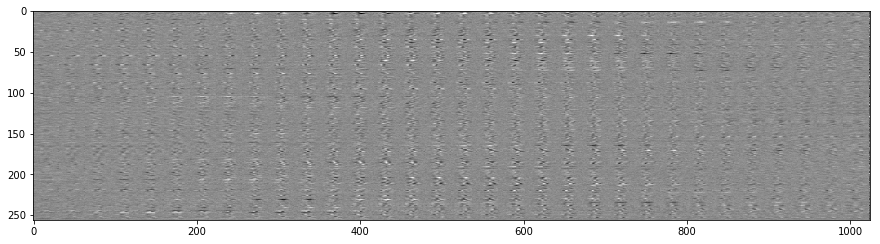

In [20]:
plt.figure(figsize=(15,8))
plt.imshow(np.squeeze(weight_array), cmap='gray')
plt.show()

# Convolutional Neural Network

In [21]:
train_data,test_data = get_dataset(root=directory,color_channel = True)


# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

In [22]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
print("Image size : ",images[0].shape)

Image size :  (3, 32, 32)


Image size :  (3, 32, 32)


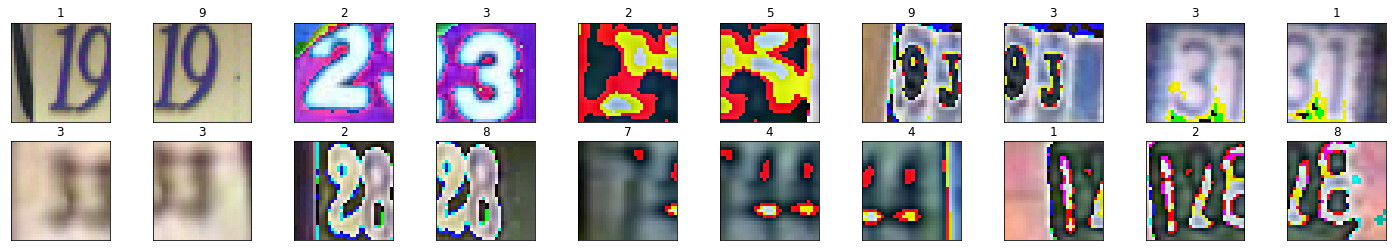

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
print("Image size : ",images[0].shape)
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(((((np.transpose(images[idx],(1,2,0))) * 255.).astype(np.uint8))))
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

## Neural Network

In [24]:
import torch.nn as nn
import torch.nn.functional as F


class ConvNet(nn.Module):
    '''Define your neural network'''
    
    def __init__(self):
        super(ConvNet,self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(3,32,3,stride=1,padding=0)
        self.conv2 = nn.Conv2d(32,64,3,stride=1,padding=0)
        self.conv3 = nn.Conv2d(64,128,3,stride=1,padding=0)
        self.pool = nn.MaxPool2d(2,2)
        self.fc = nn.Linear(128 * 6 * 6,10)
                
        
    def forward(self,x):
        # add sequence of convolutional and max pooling layers
        
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(-1,128 * 6 * 6)
        x = F.relu(self.fc(x))
        return x


## Training and Testing

In [25]:
from torch.utils.data.sampler import SubsetRandomSampler


# Pick your hyper parameters

valid_size = 0.2
max_epoch = 20
batch_size = 20
learning_rate = 0.003

use_gpu = torch.cuda.is_available()

import torch.optim as optim
import torch.nn.functional as F

def main():

    train_data,test_data = get_dataset(root=directory,color_channel = True)

    
    # obtain training indices that will be used for validation
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:],indices[:split]


    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)


    # prepare data loaders (combine dataset and sampler)
    train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,
                                               sampler=train_sampler,num_workers=num_workers)

    valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
        sampler=valid_sampler, num_workers=num_workers)
    
    
    
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=
                                                0.9, weight_decay=5e-04)
    
    if use_gpu:
        model.cuda()
    
    # start training
    train(max_epoch, model, criterion, optimizer, train_loader,valid_loader)
    
    return model

In [26]:
def train(epoch, model, criterion, optimizer, train_loader,valid_loader):
    
    valid_loss_min = np.Inf # track change in validation loss

    for epoch in range(1, max_epoch+1):

        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        model.train()
        for data, target in train_loader:
            # move tensors to GPU if CUDA is available
            if use_gpu:
                data, target = data.cuda(), target.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*data.size(0)

        ######################    
        # validate the model #
        ######################
        model.eval()
        for data, target in valid_loader:
            # move tensors to GPU if CUDA is available
            if use_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)

        # calculate average losses
        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(valid_loader.dataset)

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'model_housenumber_cnn.pt')
            valid_loss_min = valid_loss

In [27]:
model  = main()

Epoch: 1 	Training Loss: 1.181077 	Validation Loss: 0.187482
Validation loss decreased (inf --> 0.187482).  Saving model ...
Epoch: 2 	Training Loss: 0.570930 	Validation Loss: 0.096414
Validation loss decreased (0.187482 --> 0.096414).  Saving model ...
Epoch: 3 	Training Loss: 0.341982 	Validation Loss: 0.082823
Validation loss decreased (0.096414 --> 0.082823).  Saving model ...
Epoch: 4 	Training Loss: 0.293113 	Validation Loss: 0.078463
Validation loss decreased (0.082823 --> 0.078463).  Saving model ...
Epoch: 5 	Training Loss: 0.265007 	Validation Loss: 0.074243
Validation loss decreased (0.078463 --> 0.074243).  Saving model ...
Epoch: 6 	Training Loss: 0.242903 	Validation Loss: 0.074284
Epoch: 7 	Training Loss: 0.224725 	Validation Loss: 0.072416
Validation loss decreased (0.074243 --> 0.072416).  Saving model ...
Epoch: 8 	Training Loss: 0.208873 	Validation Loss: 0.073118
Epoch: 9 	Training Loss: 0.195295 	Validation Loss: 0.074825
Epoch: 10 	Training Loss: 0.183828 	Valida

In [28]:
torch.cuda.empty_cache()

In [29]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
        num_workers=num_workers)

model.load_state_dict(torch.load('model_housenumber_cnn.pt'))
criterion = nn.CrossEntropyLoss()

In [30]:
def test(model, test_loader): 

    # track test loss
    test_loss = 0
    accuracy = 0
    
    if use_gpu:
        model.cuda()
    
    
    model.eval()
    # iterate over test data
    
    with torch.no_grad(): 
    
        for data, target in test_loader:
            # move tensors to GPU if CUDA is available
            if use_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model


            log_ps = model(data)
            test_loss += criterion(log_ps, target)

            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == target.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))
            torch.cuda.empty_cache()

    # average test loss
    test_loss = test_loss/len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))
    print("Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

In [31]:
test(model, test_loader)

Test Loss: 0.020582

Test Accuracy: 0.886


## Weight Visualization

In [32]:
for name, param in model.named_parameters():
    #print(param.data.shape)
    
    if param.requires_grad:
        print(name,param.data.shape)

conv1.weight torch.Size([32, 3, 3, 3])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 3, 3])
conv2.bias torch.Size([64])
conv3.weight torch.Size([128, 64, 3, 3])
conv3.bias torch.Size([128])
fc.weight torch.Size([10, 4608])
fc.bias torch.Size([10])


In [33]:
def plot_kernels(tensor, num_cols=8):
    if not tensor.ndim==4:
        raise Exception("assumes a 4D tensor")
    if not tensor.shape[-1]==3:
        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow((tensor[i] * 255.).astype(np.uint8))
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
    
#vgg = models.vgg16(pretrained=True)
#mm = vgg.double()
#filters = mm.modules
#body_model = [i for i in mm.children()][0]
#layer1 = body_model[0]
#tensor = layer1.weight.data.numpy()
#plot_kernels(tensor)


In [34]:
temp = list(model.named_parameters())[0][1].cpu().detach().numpy()

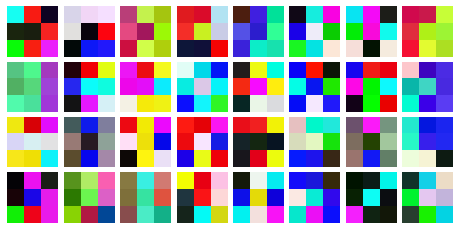

In [35]:
plot_kernels(temp)